# 3_Unsupervised - Sentiment Analysis

## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 3: Jhanvi Udani, Raj Shah, Shambhavi Bhushan 

In [2]:
import pandas as pd
import os
import nltk
import ast
import string
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rajshah/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
scenes = []
for f in os.listdir('Dataset/allScenes'):
    if not f.endswith('.csv'):
        continue
    scenes.append(pd.read_csv('Dataset/allScenes/' + f, index_col=False))

# Combining all the scene data
scenes = pd.concat(scenes)

In [5]:
scenes.sample(3)

,chars,females,males,nbs,unknowns,total_tokens,total_others,talking_about_men,importance,movie_filename
15,2,0,2,0,0,"['saw', 'two', 'cab', 'know', 'direction', 'si...","['frank', 'him', 'hoffa']",True,0.583497,The-Irishman
30,3,1,1,1,0,"['best', 'well', 'alice', 'friend', 'welcome',...","['charlie', 'alice', 'he', 'his']",True,0.373361,Perks-of-Being-a-Wallflower-The
48,1,0,1,0,0,"['go', 'click', 'full', 'tap', 'start', 'hiss'...","['she', 'her', 'him', 'prema', 'he']",True,0.537310,Concussion


In [6]:
# Function to extract sentiment details from tokens

def sentiment_details(tokens):
    text = (' ').join(ast.literal_eval(tokens))
    analyzer = SentimentIntensityAnalyzer() # Instantiating sentiment analyzer
    scores = analyzer.polarity_scores(text) # Calculating score
    # Seperating values for calculation
    neg = scores['neg']
    neu = scores['neu']
    pos = scores['pos']
    compound = scores['compound']
    return neg, neu, pos, compound  

In [7]:
# Apply the sentiment_details function to each row in the DataFrame

scene_sentiments = scenes.apply(lambda x: sentiment_details(x.total_tokens), axis=1)

In [8]:
scenes['negative'], scenes['neutral'], scenes['positive'], scenes['compound'] = zip(*scene_sentiments)
scenes.head()

,chars,females,males,nbs,unknowns,total_tokens,total_others,talking_about_men,importance,movie_filename,negative,neutral,positive,compound
0,1,1,0,0,0,"['go', 'two', 'town', 'neighboring', 'hoping',...",[],False,0.700418,Easy-A,0.134,0.707,0.160,0.5719
1,2,2,0,0,0,"['number', 'lesbo', 'well', 'two', 'ben', 'spe...","['he', 'him']",True,0.459787,Easy-A,0.226,0.542,0.232,-0.5423
2,1,1,0,0,0,"['met', 'let', 'know', 'people', 'radius', 'qu...",['rhiannon'],False,0.260719,Easy-A,0.000,1.000,0.000,0.0000
3,1,1,0,0,0,"['felt', 'asking', 'sorry', 'sort', 'rhiannon'...","['she', 'rhiannon']",False,0.182388,Easy-A,0.178,0.822,0.000,-0.0772
4,1,1,0,0,0,"['pay', 'begging', 'please']",[],False,0.067097,Easy-A,0.298,0.213,0.489,0.2263


In [9]:
# Calculate whether scenes pass the Bechdel test
scenes['passesBechdel'] = (scenes['chars'] >= 2) & (scenes['males'] < 1) & (scenes['talking_about_men'] == False)

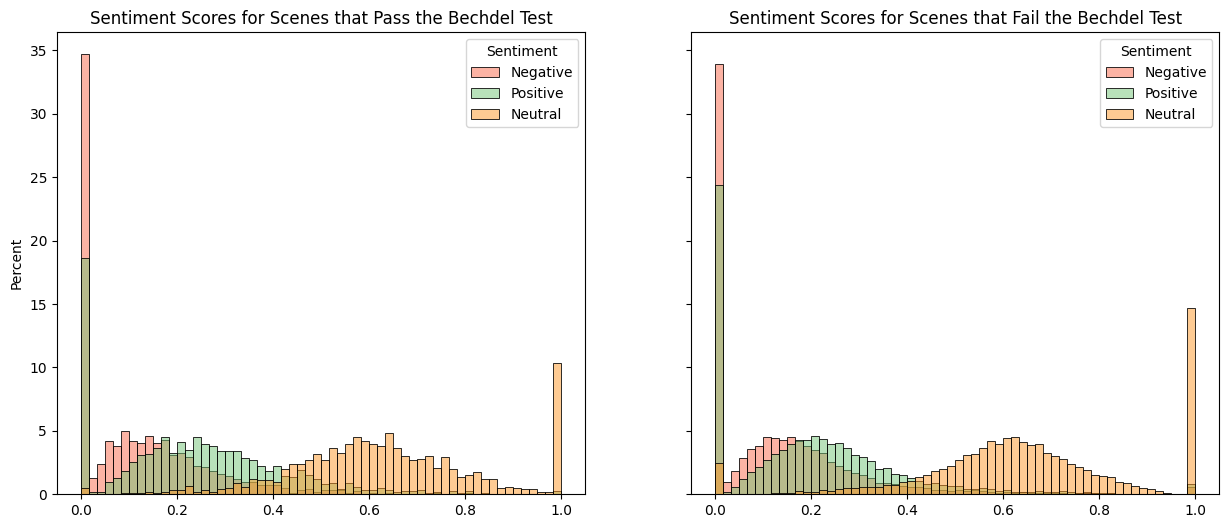

In [17]:
# Visualizing the sentiments for movies which pass and fail the Bechdel test
pass_bechdel = pd.melt(scenes[scenes['passesBechdel'] == True][['negative', 'neutral', 'positive', 'compound']], var_name='score')
fail_bechdel = pd.melt(scenes[scenes['passesBechdel'] == False][['negative', 'neutral', 'positive', 'compound']], var_name='score')

fig, ax = plt.subplots(1,2, figsize = (15,6), sharey = True)

sns.histplot(data = pass_bechdel[pass_bechdel['score'] == 'negative'],label='Negative', palette='Reds', legend=False, ax=ax[0], stat='percent', bins=60)
sns.histplot(data = pass_bechdel[pass_bechdel['score'] == 'positive'], label='Positive', palette='Greens', legend=False, ax=ax[0], stat='percent', bins=60)
sns.histplot(data = pass_bechdel[pass_bechdel['score'] == 'neutral'],label='Neutral', palette='YlOrBr', legend=False, ax=ax[0], stat='percent', bins=60)

ax[0].set_title('Sentiment Scores for Scenes that Pass the Bechdel Test')
ax[0].legend(title='Sentiment')

sns.histplot(data = fail_bechdel[fail_bechdel['score'] == 'negative'],label='Negative', palette='Reds', legend=False, ax=ax[1], stat='percent', bins=60)
sns.histplot(data = fail_bechdel[fail_bechdel['score'] == 'positive'],label='Positive', palette='Greens', legend=False, ax=ax[1], stat='percent', bins=60)
sns.histplot(data = fail_bechdel[fail_bechdel['score'] == 'neutral'],label='Neutral', palette='YlOrBr', legend=False, ax=ax[1], stat='percent', bins=60)
ax[1].set_title('Sentiment Scores for Scenes that Fail the Bechdel Test')
ax[1].legend(title='Sentiment')


In [11]:
print(scenes[scenes['passesBechdel'] == True].compound.mean(), scenes[scenes['passesBechdel'] == False].compound.mean())

0.26216253776435045 0.1616672937241992


<AxesSubplot:ylabel='Percent'>

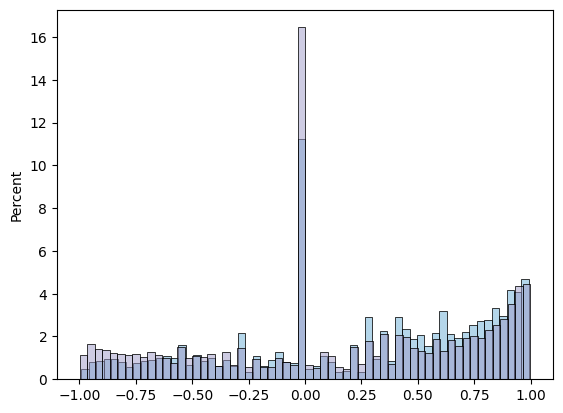

In [50]:
# Visualize compound sentiment scores for scenes that pass and fail the Bechdel test

sns.histplot(data = pass_bechdel[pass_bechdel['score'] == 'compound'], bins=60, stat='percent', palette='Blues', legend=False)
sns.histplot(data = fail_bechdel[fail_bechdel['score'] == 'compound'], bins=60, stat='percent', palette='Purples', legend=False)


# Chart Set 1
Distributions were mostly the same between the two groups.

Now, let's see how sentiment is correlated with our statistics.

In [58]:
# Correlation analysis between sentiment scores and statistics


scene_corr = scenes[['chars', 'females', 'males', 'nbs','talking_about_men','passesBechdel', 'negative', 'positive', 'neutral', 'compound']].corr()

<AxesSubplot:>

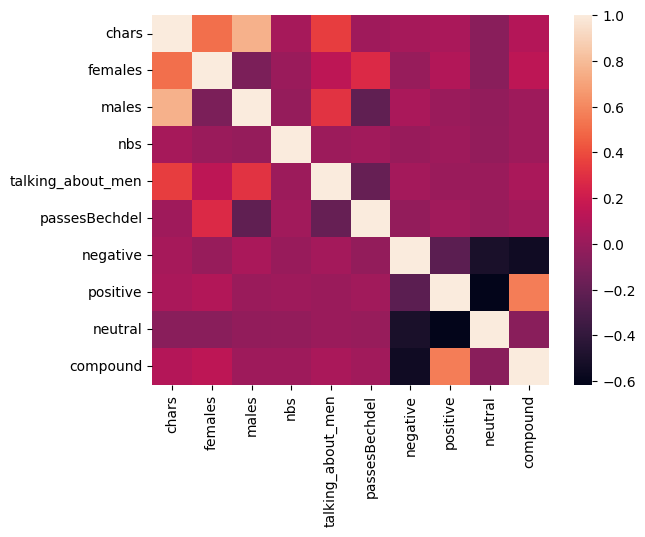

In [59]:
sns.heatmap(scene_corr)

Not much - looks like sentiments are not correlated at all with the character count.

References- 
1. https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
2. https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/
3. https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/
4. https://stackoverflow.com/questions/31186019/rotate-tick-labels-in-subplot
